<a href="https://colab.research.google.com/github/emekaokoye/dsn_bootcamp_2024/blob/main/Medical_QA_System_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00
Initializing Medical QA System...
Loading BERT model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Models loaded successfully!

Visualizing the Medical Knowledge Graph:


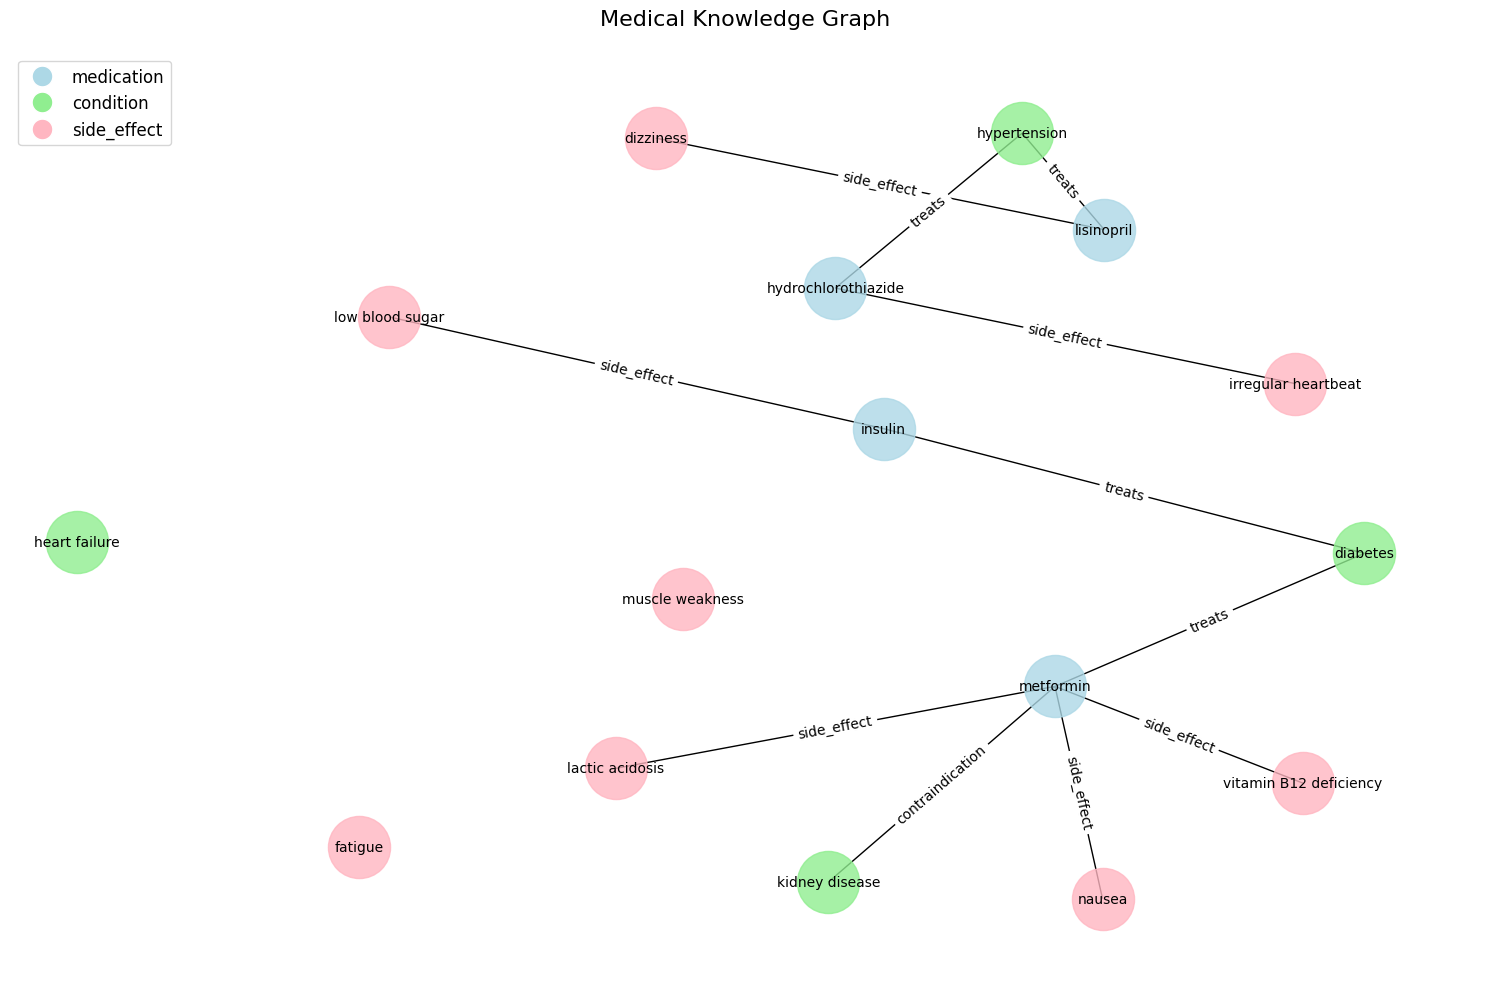


Processing example questions:
--------------------------------------------------

Question: What are the side effects of metformin?

Response: 
Information about Metformin:

Primary use:
- Used to treat diabetes

Known side effects:
- Lactic acidosis
- Vitamin b12 deficiency
- Nausea

Contraindications:
- Kidney disease

CAUTION: This is a demonstration system. Always consult with a healthcare provider for medical advice.
--------------------------------------------------

Question: What are the side effects of insulin?

Response: 
Information about Insulin:

Primary use:
- Used to treat diabetes

Known side effects:
- Low blood sugar

CAUTION: This is a demonstration system. Always consult with a healthcare provider for medical advice.
--------------------------------------------------

Question: What are the side effects of lisinopril?

Response: 
Information about Lisinopril:

Primary use:
- Used to treat hypertension

Known side effects:
- Dizziness

CAUTION: This is a demonstrati

In [1]:
# Install required packages
!pip install torch torch_geometric transformers networkx pandas matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from transformers import AutoTokenizer, AutoModel
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

class MedicalKnowledgeGraph:
    def __init__(self):
        self.graph = nx.Graph()

        # Define entity lists
        medications = ['metformin', 'insulin', 'lisinopril', 'hydrochlorothiazide']
        conditions = ['diabetes', 'kidney disease', 'hypertension', 'heart failure']
        side_effects = ['lactic acidosis', 'low blood sugar', 'dizziness',
                       'nausea', 'vitamin B12 deficiency', 'fatigue',
                       'muscle weakness', 'irregular heartbeat']

        # Add nodes with types
        for med in medications:
            self.graph.add_node(med, node_type='medication')
        for cond in conditions:
            self.graph.add_node(cond, node_type='condition')
        for effect in side_effects:
            self.graph.add_node(effect, node_type='side_effect')

        # Add relationships
        relationships = [
            ('metformin', 'diabetes', 'treats'),
            ('metformin', 'lactic acidosis', 'side_effect'),
            ('metformin', 'vitamin B12 deficiency', 'side_effect'),
            ('metformin', 'kidney disease', 'contraindication'),
            ('metformin', 'nausea', 'side_effect'),
            ('insulin', 'diabetes', 'treats'),
            ('insulin', 'low blood sugar', 'side_effect'),
            ('lisinopril', 'hypertension', 'treats'),
            ('lisinopril', 'dizziness', 'side_effect'),
            ('hydrochlorothiazide', 'hypertension', 'treats'),
            ('hydrochlorothiazide', 'irregular heartbeat', 'side_effect')
        ]

        for source, target, relation in relationships:
            self.graph.add_edge(source, target, relation=relation)

    def visualize(self):
        """Visualize the knowledge graph with color-coded nodes and relationship labels."""
        plt.figure(figsize=(15, 10))

        # Create layout
        pos = nx.spring_layout(self.graph, k=1, iterations=50)

        # Draw nodes with different colors based on type
        color_map = {'medication': 'lightblue',
                    'condition': 'lightgreen',
                    'side_effect': 'lightpink'}

        for node_type in ['medication', 'condition', 'side_effect']:
            nodes = [node for node, attr in self.graph.nodes(data=True)
                    if attr.get('node_type') == node_type]
            nx.draw_networkx_nodes(self.graph, pos, nodelist=nodes,
                                 node_color=color_map[node_type],
                                 node_size=2000, alpha=0.8)

        # Draw edges and labels
        nx.draw_networkx_edges(self.graph, pos)
        nx.draw_networkx_labels(self.graph, pos, font_size=10)

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.graph, 'relation')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels)

        # Add legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=color, label=node_type,
                                    markersize=15)
                         for node_type, color in color_map.items()]
        plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

        plt.title("Medical Knowledge Graph", fontsize=16, pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def query(self, entity, relation_type=None):
        """Query the knowledge graph for information about an entity."""
        if entity not in self.graph:
            return []

        related_info = []
        for neighbor in self.graph.neighbors(entity):
            edge_data = self.graph.get_edge_data(entity, neighbor)
            if relation_type is None or edge_data['relation'] == relation_type:
                related_info.append((neighbor, edge_data['relation']))
        return related_info

class MedicalQASystem:
    def __init__(self):
        # Initialize knowledge graph
        self.knowledge_graph = MedicalKnowledgeGraph()

        # Initialize BERT model and tokenizer
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.language_model = AutoModel.from_pretrained('bert-base-uncased')
        print("Models loaded successfully!")

    def process_question(self, question):
        """Process question using BERT."""
        inputs = self.tokenizer(question, return_tensors="pt",
                              padding=True, truncation=True)
        outputs = self.language_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].detach()

    def query_knowledge_graph(self, entity, relation_type=None):
        """Query the knowledge graph for information."""
        return self.knowledge_graph.query(entity, relation_type)

    def generate_response(self, question):
        """Generate a response based on the question and knowledge graph."""
        question = question.lower()

        # Extract medication name from question (simplified)
        medications = ['metformin', 'insulin', 'lisinopril', 'hydrochlorothiazide']
        mentioned_med = None
        for med in medications:
            if med in question:
                mentioned_med = med
                break

        if not mentioned_med:
            return ("I can only answer questions about these medications: " +
                   ", ".join(medications))

        # Build response based on query type
        if 'side effect' in question or 'side effects' in question:
            side_effects = self.query_knowledge_graph(mentioned_med, 'side_effect')
            contraindications = self.query_knowledge_graph(mentioned_med, 'contraindication')
            treats = self.query_knowledge_graph(mentioned_med, 'treats')

            response = f"\nInformation about {mentioned_med.capitalize()}:\n\n"

            # What it treats
            response += "Primary use:\n"
            for condition, _ in treats:
                response += f"- Used to treat {condition}\n"

            # Side effects
            response += "\nKnown side effects:\n"
            for effect, _ in side_effects:
                response += f"- {effect.capitalize()}\n"

            # Contraindications
            if contraindications:
                response += "\nContraindications:\n"
                for condition, _ in contraindications:
                    response += f"- {condition.capitalize()}\n"

            response += "\nCAUTION: This is a demonstration system. "
            response += "Always consult with a healthcare provider for medical advice."

            return response
        else:
            return ("I can answer questions about side effects of medications. "
                   "Please rephrase your question.")

def demonstrate_medical_qa():
    """Run a demonstration of the Medical QA system."""
    print("Initializing Medical QA System...")
    qa_system = MedicalQASystem()

    print("\nVisualizing the Medical Knowledge Graph:")
    qa_system.knowledge_graph.visualize()

    # Example questions
    questions = [
        "What are the side effects of metformin?",
        "What are the side effects of insulin?",
        "What are the side effects of lisinopril?",
        "What about aspirin?" # Test unknown medication
    ]

    print("\nProcessing example questions:")
    print("-" * 50)

    for question in questions:
        print(f"\nQuestion: {question}")
        response = qa_system.generate_response(question)
        print("\nResponse:", response)
        print("-" * 50)

# Run the demonstration
if __name__ == "__main__":
    demonstrate_medical_qa()